# 1. Unsupervised Learning

In [2]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt
from numpy import linalg as LA

## 1. Generating the data

First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. Since you generated the data, you already know which sample comes from which class.
  Run the cell in the IPython notebook to generate the data.

In [3]:
# TODO: Run this cell to generate the data
num_samples = 400
cov = np.array([[1., .7], [.7, 1.]]) * 10
mean_1 = [.1, .1]
mean_2 = [6., .1]

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples // 2)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples // 2)
xy_class1 = np.column_stack((x_class1, np.zeros(num_samples // 2)))
xy_class2 = np.column_stack((x_class2, np.ones(num_samples // 2)))
data_full = np.row_stack([xy_class1, xy_class2])
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]

Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

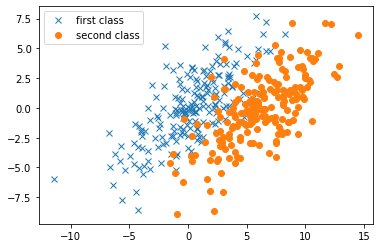

In [4]:
# TODO: Make a scatterplot for the data points showing the true cluster assignments of each point
p1 = plt.plot(x_class1[:,0], x_class1[:,1], 'x')
p2 = plt.plot(x_class2[:,0], x_class2[:,1], 'o')
plt.legend((p1[0], p2[0]), ('first class', 'second class'))
# plt.plot(...) # first class, x shape
# plt.plot(...) # second class, circle shape

## 2. Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat\mu_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat\mu_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost vs. the number of iterations. Report your misclassification error.

In [5]:
def cost(data, R, Mu):
    N, D = data.shape
    K = Mu.shape[1]
    J = 0
    for k in range(K):
        J += np.sum(np.dot(np.linalg.norm(data - np.array([Mu[:, k], ] * N), axis=1)**2, R))
    return J

In [6]:
# TODO: K-Means Assignment Step
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    # Fill this in:
    N, D = data.shape[0], data.shape[1] # Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = np.zeros((N, K))
    for k in range(K):
        mu_k = Mu[:,k]
        new_nu = np.tile(np.transpose(mu_k),(N, 1))
        diff = data - new_nu
        r[:, k] = LA.norm(diff, axis=1)
    # print(r)
    arg_min = np.argmin(r, axis=1) # argmax/argmin along dimension 1
    R_new = np.zeros((N,K)) # Set to zeros/ones with shape (N, K)
    for n in range(N):
        R_new[n, arg_min[n]]=1
    # R_new[..., ...] = 1 # Assign to 1
    # print(arg_min)
    return R_new

In [7]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape[0], data.shape[1] # Number of datapoints and dimension of datapoint
    K = Mu.shape[1]  # number of clusters
    Mu_index = np.argmax(R, axis=0)
    Mu_new = np.zeros((D, K))
    factor = np.sum(R, axis=0)
    Mu_new = np.zeros((D, K))
    for k in range(K):
        num = np.zeros((1, D))
        for n in range(N):
            num+=data[n,:]*R[n,k]
        Mu_new[:,k] = num/np.sum(R[:,k])
    return Mu_new

Error is 22.50%


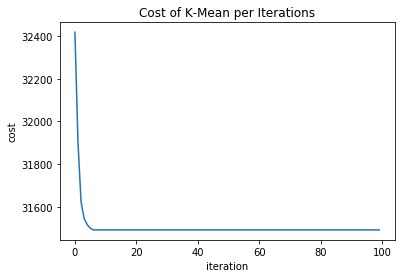

In [8]:
# TODO: Run this cell to call the K-means algorithm
def K_means(data, labels, log_like=False):
    N, D = data.shape
    K = 2
    max_iter = 100
    class_init = np.random.binomial(1., .5, size=N)
    R = np.vstack([class_init, 1 - class_init]).T

    Mu = np.zeros([D, K])
    Mu[:, 1] = 1.
    R.T.dot(data), np.sum(R, axis=0)

    costs_it = []
    iteration = []
    for it in range(max_iter):
        R = km_assignment_step(data, Mu)
        Mu = km_refitting_step(data, R, Mu)
        # print(R)
        iteration.append(it)
        c = cost(data, R, Mu)
        costs_it.append(cost(data, R, Mu)) 
    labels_predict = np.argwhere(R==1)[:,1]
    error=np.mean(labels!=labels_predict)*100
    print("Error is {0:.2f}%".format(error))
    if(log_like==True):
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(iteration, costs_it)
        plt.title("Cost of K-Mean per Iterations")
        plt.xlabel("iteration")
        plt.ylabel("cost")
    class_1 = np.where(R[:, 0])
    class_2 = np.where(R[:, 1])
    return class_1, class_2, error
class_1, class_2, error = K_means(data, labels, log_like=True)

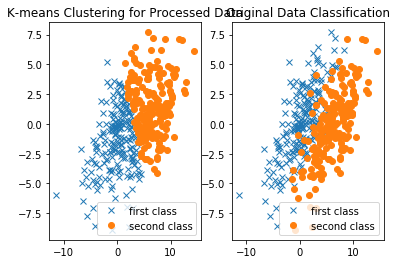

In [9]:
# TODO: Make a scatterplot for the data points showing the K-Means cluster assignments of each point
def graph_k_mean(class_1, class_2):
    data1 = []
    data2 = []
    for i in class_1:
        data1.append(data[i,:])
    for j in class_2:
        data2.append(data[j,:])
    data1 = np.matrix(data1[0])
    data2 = np.matrix(data2[0])
    plt.subplot(121)
    p1 = plt.plot(data1[:,0], data1[:,1], 'x')
    p2 = plt.plot(data2[:,0], data2[:,1], 'o')
    plt.legend((p1[0], p2[0]), ('first class', 'second class'))
    plt.title("K-means Clustering for Processed Data")
    plt.subplot(122)
    data_org1=[]
    data_org2=[]
    for i in range(len(data_full)):
        if(data_full[i][2]==0):
            data_org1.append(data_full[i][:2])
        else:
            data_org2.append(data_full[i][:2])
    data_org1 = np.matrix(data_org1)
    data_org2 = np.matrix(data_org2)
    p1 = plt.plot(data_org1[:,0], data_org1[:,1], 'x')
    p2 = plt.plot(data_org2[:,0], data_org2[:,1], 'o')
    plt.legend((p1[0], p2[0]), ('first class', 'second class'))
    plt.title("Original Data Classification")
graph_k_mean(class_1, class_2)

## 3. Implement EM algorithm for Gaussian mixtures
Next, implement the EM algorithm for Gaussian mixtures.
  Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  Identify the correct arguments, and the order to run them.
  Initialize the algorithm with means as in Qs 2.1 k-means initialization, covariances with $\hat\Sigma_1=\hat\Sigma_2=I$,
  and $\hat\pi_1=\hat\pi_2$.

  In addition to the update equations in the lecture, for the M (Maximization) step, you also need to use this following equation to update the covariance $\Sigma_k$:
$$\hat{\mathbf{\Sigma}_k} = \frac{1}{N_k} \sum^N_{n=1} r_k^{(n)}(\mathbf{x}^{(n)} - \hat{\mathbf{\mu}_k})(\mathbf{x}^{(n)} - \hat{\mathbf{\mu}_k})^{\top}$$
    
  Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [10]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

In [11]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    # Fill this in:
    N, D = data.shape  # Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of mixtures
    L, T = 0., 0.
    for n in range(N):
        T=0.0
        for k in range(K):
            T += normal_density(data[n,:], Mu[:,k], Sigma[k])*Pi[k]
            # Compute the likelihood from the k-th Gaussian weighted by the mixing coefficients 
        L += np.log(T)
    return L

In [12]:
# TODO: Gaussian Mixture Expectation Step
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    # Fill this in:
    N, D = data.shape  # Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of mixtures
    Gamma = np.zeros((N,K)) # zeros of shape (N,K), matrix of responsibilities
    for n in range(N):
        for k in range(K):
            Gamma[n,k] = Pi[k]*normal_density(data[n,:], Mu[:,k], Sigma[k])
        # Gamma[n, :] /= np.sum(Gamma[n,:]) # Normalize by sum across second dimension (mixtures)
        Gamma[n, :] =  Gamma[n, :] / np.sum(Gamma[n,:])
    return Gamma

In [13]:
# TODO: Gaussian Mixture Maximization Step
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # number of mixtures
    Nk = np.sum(Gamma, axis=0) # Sum along first axis 
    Mu = np.dot(np.transpose(data), Gamma)/Nk[None,:]
    Sigma = [0]*K
    for k in range(K):
        t=np.zeros((D, D))
        Muk=Mu[:,k]
        for n in range(N):
            diff = np.reshape(data[n, :] - Muk,(-1,1))
            t = t+ np.dot(diff, np.reshape(diff, (1, -1)))*Gamma[n, k]
        Sigma[k] = t/Nk[k] 
    Pi = Nk/N
    return Mu, Sigma, Pi

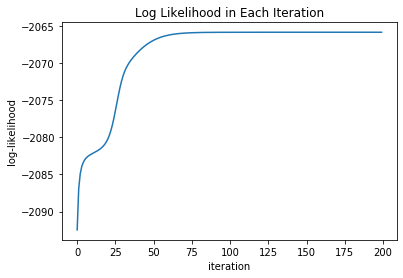

Error is 8.75%


In [17]:
# TODO: Run this cell to call the Gaussian Mixture EM algorithm
def EM(data, labels, log_like = False):
    N, D = data.shape
    K = 2
    Mu = np.zeros([D, K])
    Mu[:, 1] = 1.
    Sigma = [np.eye(2), np.eye(2)]
    Pi = np.ones(K) / K
    Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

    max_iter  = 200
    iteration=[]
    log = []
    for it in range(max_iter):
        Gamma = gm_e_step(data, Mu, Sigma, Pi)
        Mu, Sigma, Pi = gm_m_step(data, Gamma)
        iteration.append(it)
        log.append(log_likelihood(data, Mu, Sigma, Pi))
    if(log_like==True):
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(iteration, log)
        plt.title("Log Likelihood in Each Iteration")
        plt.xlabel("iteration")
        plt.ylabel("log-likelihood")
        plt.show()
    class_1 = np.where(Gamma[:, 0] >= .5)
    class_2 = np.where(Gamma[:, 1] >= .5)
    R3 = np.round(Gamma)
    labels_predict2 = np.argwhere(np.matrix(R3)==1)[:,1]
    error = np.mean(labels!=labels_predict2)*100
    print("Error is {0:.2f}%".format(error))
    return class_1, class_2, error
class_1, class_2, error = EM(data, labels, log_like=True)

Text(0.5, 1.0, 'Original Data Classification')

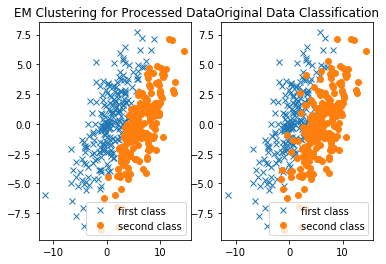

In [18]:
# TODO: Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point
data1 = []
data2 = []
for i in class_1:
    data1.append(data[i,:])
for j in class_2:
    data2.append(data[j,:])
data1 = np.matrix(data1[0])
data2 = np.matrix(data2[0])
plt.subplot(121)
p1 = plt.plot(data1[:,0], data1[:,1], 'x')
p2 = plt.plot(data2[:,0], data2[:,1], 'o')
plt.legend((p1[0], p2[0]), ('first class', 'second class'))
plt.title("EM Clustering for Processed Data")
data_org1=[]
data_org2=[]
for i in range(len(data_full)):
    if(data_full[i][2]==0):
        data_org1.append(data_full[i][:2])
    else:
        data_org2.append(data_full[i][:2])
data_org1 = np.matrix(data_org1)
data_org2 = np.matrix(data_org2)
plt.subplot(122)
p1 = plt.plot(data_org1[:,0], data_org1[:,1], 'x')
p2 = plt.plot(data_org2[:,0], data_org2[:,1], 'o')
plt.legend((p1[0], p2[0]), ('first class', 'second class'))
plt.title("Original Data Classification")

## 4. Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments.
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method?
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data?
 


**TODO: Your written answer here**

* 1) Compared with k-means, EM has much smaller errors for clustering, which is more similar to orignial data. 
* 2) K-means converges about its 5th iteration, way faster than EM which not converged untill its 50th iteration.
* 3) 5 differet data realization shows the same pattern as in 1), 2). That is, although k-means converges faster than EM, it gnereally has lower accuracy than EM method

----------K Means
Error is 28.00%
----------EM
Error is 11.75%
----------K Means
Error is 23.50%
----------EM
Error is 14.75%
----------K Means
Error is 26.50%
----------EM
Error is 16.25%
----------K Means
Error is 23.75%
----------EM
Error is 9.50%
----------K Means
Error is 26.25%
----------EM
Error is 6.50%


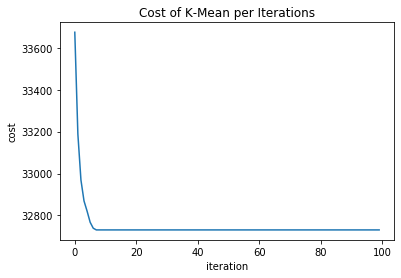

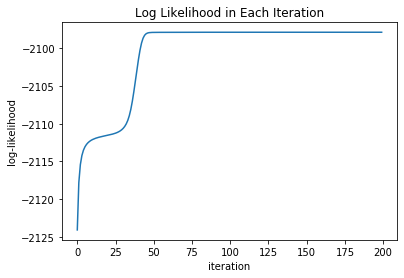

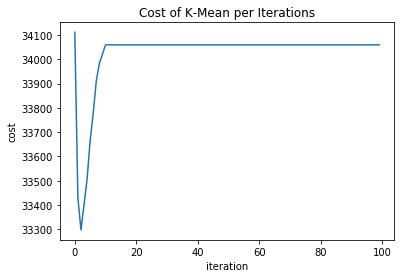

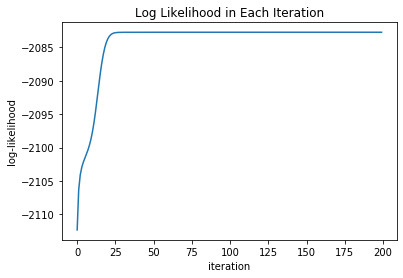

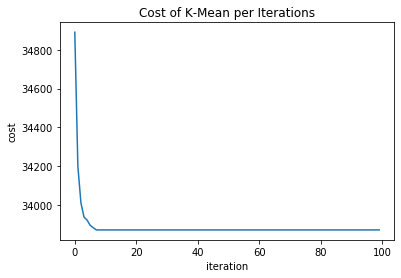

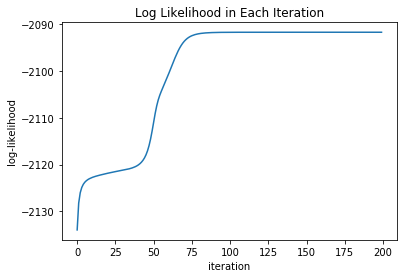

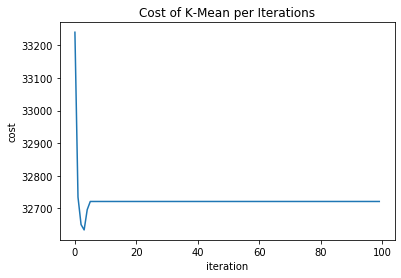

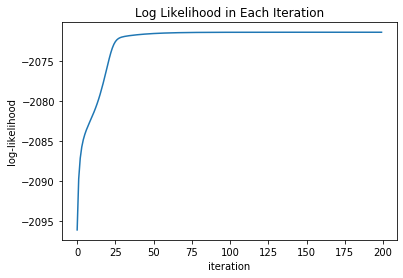

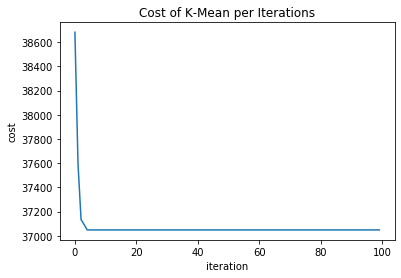

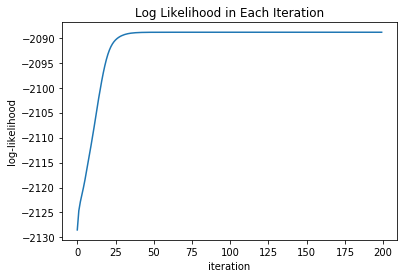

Text(0.5, 1.0, 'Data error for different clustering method')

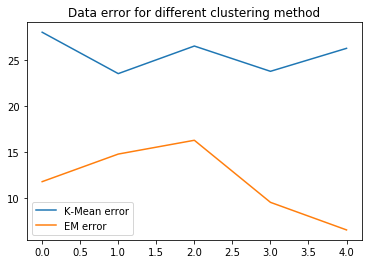

In [21]:
## For different data mean and cov
def generate_data(num_samples, cov, mean_1, mean_2):
    x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples // 2)
    x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples // 2)
    xy_class1 = np.column_stack((x_class1, np.zeros(num_samples // 2)))
    xy_class2 = np.column_stack((x_class2, np.ones(num_samples // 2)))
    data_full = np.row_stack([xy_class1, xy_class2])
    np.random.shuffle(data_full)
    data = data_full[:, :2]
    labels = data_full[:, 2]
    return data, labels

### For same mean, same cov, same distribution
eM_acc=[]
kM_acc=[]
iteration = []
for i in range(5):
    iteration.append(i)
    # num_samples=400
    # A = np.random.rand(2,2)
    # cov=np.dot(A, A.transpose())
    # mean_1=np.random.rand(1,2)[0]
    # mean_2=np.random.rand(1,2)[0]
    data, labels = generate_data(num_samples, cov, mean_1, mean_2)
    print("----------K Means")
    class_1, class_2, error = K_means(data,labels, log_like=True)
    # class_1, class_2, error = K_means(data,labels)
    kM_acc.append(error)
    print("----------EM")
    class_1, class_2, error = EM(data, labels, log_like=True)
    eM_acc.append(error)
f1=plt.figure()
ax1 = f1.add_subplot(111)
p1 = ax1.plot(iteration, kM_acc)
p2 = ax1.plot(iteration, eM_acc)
plt.legend((p1[0], p2[0]), ('K-Mean error', 'EM error'))
plt.title("Data error for different clustering method")

# 2. Reinforcement Learning

There are 3 files:
1. `maze.py`: defines the `MazeEnv` class, the simulation environment which the Q-learning agent will interact in.
2. `qlearning.py`: defines the `qlearn` function which you will implement, along with several helper functions. Follow the instructions in the file. 
3. `plotting_utils.py`: defines several plotting and visualization utilities. In particular, you will use `plot_steps_vs_iters`, `plot_several_steps_vs_iters`, `plot_policy_from_q`

In [23]:
from qlearning import qlearn
from maze import MazeEnv, ProbabilisticMazeEnv
from plotting_utils import plot_steps_vs_iters, plot_several_steps_vs_iters, plot_policy_from_q

## 1. Basic Q Learning experiments

(a) Run your algorithm several times on the given environment. Use the following hyperparameters:
1. Number of episodes = 200
2. Alpha ($\alpha$) learning rate = 1.0
2. Maximum number of steps per episode = 100. An episode ends when the agent reaches a goal state, or uses the maximum number of steps per episode
3. Gamma ($\gamma$) discount factor = 0.9
4. Epsilon ($\epsilon$) for $\epsilon$-greedy = 0.1 (10% of the time)


In [24]:
from qlearning import qlearn
from maze import MazeEnv, ProbabilisticMazeEnv
from plotting_utils import plot_steps_vs_iters, plot_several_steps_vs_iters, plot_policy_from_q

# TODO: Fill this in
num_iters = 200
alpha = 1.0
gamma = 0.9
epsilon = 0.1
max_steps = 100
use_softmax_policy = False

# TODO: Instantiate the MazeEnv environment with default arguments
env = MazeEnv()
env.reset()
# TODO: Run Q-learning:
q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)
# print(q_hat)

Plot the steps to goal vs training iterations (episodes):

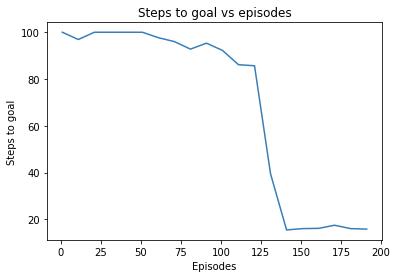

In [25]:
# TODO: Plot the steps vs iterations
plot_steps_vs_iters(steps_vs_iters)

Visualize the learned greedy policy from the Q values:

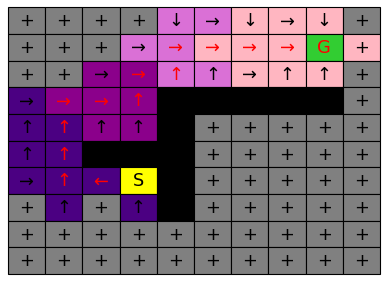

<Figure size 720x720 with 0 Axes>

In [26]:
# TODO: plot the policy from the Q value
plot_policy_from_q(q_hat, env)

(b) Run your algorithm by passing in a list of 2 goal locations: (1,8) and (5,6). Note: we are using 0-indexing, where (0,0) is top left corner. Report on the results.

In [27]:
from qlearning import qlearn
from maze import MazeEnv, ProbabilisticMazeEnv
from plotting_utils import plot_steps_vs_iters, plot_several_steps_vs_iters, plot_policy_from_q
# TODO: Fill this in (same as before)
num_iters = 200
alpha = 1.0
gamma = 0.9
epsilon = 0.1
max_steps = 100
use_softmax_policy = False

# TODO: Set the goal
goal_locs = [[1,8],[5,6]]
env = MazeEnv(goals=goal_locs)
env.reset()

# TODO: Run Q-learning:
q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)

Plot the steps to goal vs training iterations (episodes):

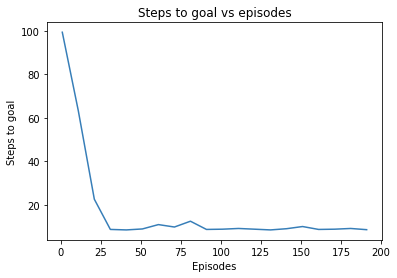

In [28]:
# TODO: Plot the steps vs iterations
plot_steps_vs_iters(steps_vs_iters)

Plot the steps to goal vs training iterations (episodes):

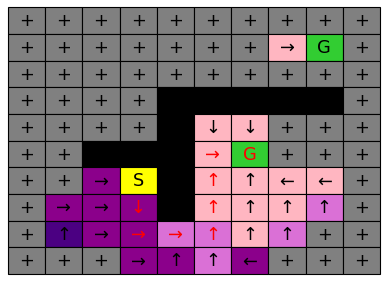

<Figure size 720x720 with 0 Axes>

In [29]:
# TODO: plot the policy from the Q values
plot_policy_from_q(q_hat, env)

## 2. Experiment with the exploration strategy, in the original environment

(a) Try different $\epsilon$ values in $\epsilon$-greedy exploration: We asked you to use a rate of $\epsilon$=10%, but try also 50% and 1%. Graph the results (for 3 epsilon values) and discuss the costs and benefits of higher and lower exploration rates.

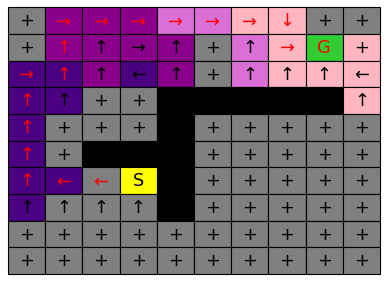

<Figure size 720x720 with 0 Axes>

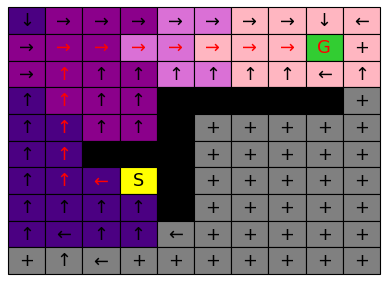

<Figure size 720x720 with 0 Axes>

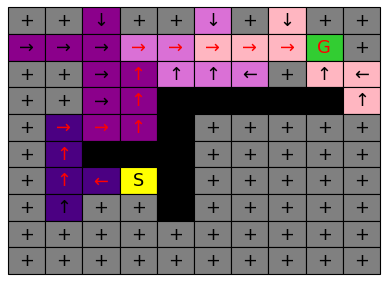

<Figure size 720x720 with 0 Axes>

In [3]:
from qlearning import qlearn
from maze import MazeEnv, ProbabilisticMazeEnv
from plotting_utils import plot_steps_vs_iters, plot_several_steps_vs_iters, plot_policy_from_q
# TODO: Fill this in (same as before)
num_iters = 200
alpha = 1.0
gamma = 0.9
max_steps = 100
use_softmax_policy = False

# TODO: set the epsilon lists in increasing order:
epsilon_list = [0.1, 0.5, 0.01]

env = MazeEnv()
env.reset()

steps_vs_iters_list = []
for epsilon in epsilon_list:
   q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)
   steps_vs_iters_list.append(steps_vs_iters)
   plot_policy_from_q(q_hat, env)

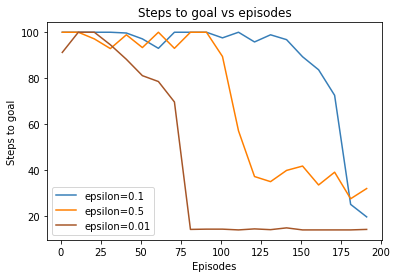

In [4]:
# TODO: Plot the results
label_list = ["epsilon={}".format(eps) for eps in epsilon_list]
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

In conclusion, with larger exploration rate $\epsilon$, the learing process converges slower, and has worse generalization to ideal solution and larger errors. Conversely, smaller exploration rate makes the process take shorter to converge, and in the end, has fewer steps to goal, we are more certain with the path(longer) we are taking.

(b) Try exploring with policy derived from **softmax of Q-values** described in the Q learning lecture. Use the values of $\beta \in \{1, 3, 6\}$ for your experiment, keeping $\beta$ fixed throughout the training.

In [32]:
from qlearning import qlearn
from maze import MazeEnv, ProbabilisticMazeEnv
from plotting_utils import plot_steps_vs_iters, plot_several_steps_vs_iters, plot_policy_from_q
# TODO: Fill this in for Static Beta with softmax of Q-values
num_iters = 200
alpha = 1.0
gamma = 0.9
max_steps = 100
epsilon=0.1

# TODO: Set the beta
beta_list = [1,3,6]
use_softmax_policy = True
k_exp_schedule = 0. # (float) choose k such that we have a constant beta during training

env = MazeEnv()
steps_vs_iters_list = []
for beta in beta_list:
    q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy, init_beta=beta, k_exp_sched=k_exp_schedule)
    steps_vs_iters_list.append(steps_vs_iters)
    # plot_policy_from_q(q_hat, env)

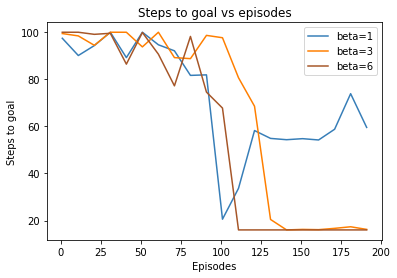

In [34]:
label_list = ["beta={}".format(beta) for beta in beta_list]
# TODO: 
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

With larger beta, the data converges slower, while has more stable performance after learning.

(c) Instead of fixing the $\beta = \beta_0$ to the initial value, we will increase the value of $\beta$ as the number of episodes $t$ increase:

$$\beta(t) = \beta_0 e^{kt}$$

That is, the $\beta$ value is fixed for a particular episode.
Run the training again for different values of $k \in \{0.05, 0.1, 0.25, 0.5\}$, keeping $\beta_0 = 1.0$. Compare the results obtained with this approach to those obtained with a static $\beta$ value.

In [45]:
# TODO: Fill this in for Dynamic Beta
num_iters = 200
alpha = 1.0
gamma = 0.9
max_steps = 100
epsilon=0.1

# TODO: Set the beta
beta = 1.0
use_softmax_policy = True
k_exp_schedule_list = [0., 0.05, 0.1, 0.25, 0.5]
env = MazeEnv()
steps_vs_iters_list=[]
for k_exp_schedule in k_exp_schedule_list:
    q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy, init_beta=beta, k_exp_sched=k_exp_schedule)
    steps_vs_iters_list.append(steps_vs_iters)
        # plot_policy_from_q(q_hat, env)

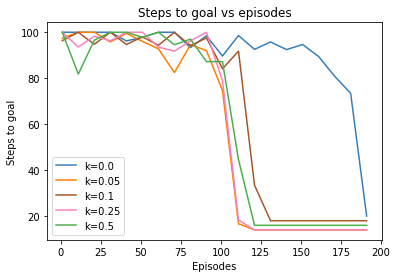

In [46]:
# TODO: Plot the steps vs iterations
label_list = ["k={}".format(k_exp_schedule) for k_exp_schedule in k_exp_schedule_list]
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

Compared with static beta, beta that is changing in each episode converges much faster 

## 3. Stochastic Environments

(a) Make  the  environment  stochastic  (uncertain),  such  that  the  agent  only  has  a  95% chance  of  moving  in  the  chosen  direction,  and  has  a  5%  chance  of  moving  in  some random direction.

In [0]:
# TODO: Implement ProbabilisticMazeEnv in maze.py

(b) Change the learning rule to handle the non-determinism, and experiment with different probability of environment performing random action $p_{rand} \in \{0.05, 0.1, 0.25, 0.5\}$ in this new rule. How does performance vary as the environment becomes more stochastic?

Use the same parameters as in first part, except change the alpha ($\alpha$) value to be **less than 1**, e.g. 0.5.

In [51]:
import numpy as np
# TODO: Fill this in for Dynamic Beta
num_iters = 200
alpha = 0.5
gamma = 0.9
epsilon = 0.1
max_steps = 100
use_softmax_policy = False

# Set the environment probability of random
env_p_rand_list = [0, 0.05, 0.1, 0.25, 0.5]

steps_vs_iters_list = []
for env_p_rand in env_p_rand_list:
    # Instantiate with ProbabilisticMazeEnv
    env = ProbabilisticMazeEnv(p_random = env_p_rand)

    # Note: We will repeat for several runs of the algorithm to make the result less noisy
    avg_steps_vs_iters = np.zeros(num_iters)
    for i in range(10):
        q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)
        avg_steps_vs_iters += steps_vs_iters
    # plot_policy_from_q(q_hat, env)
    avg_steps_vs_iters /= 10
    steps_vs_iters_list.append(avg_steps_vs_iters)

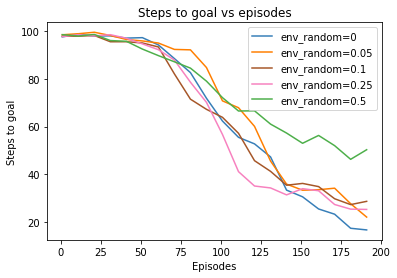

In [52]:
label_list = ["env_random={}".format(env_p_rand) for env_p_rand in env_p_rand_list]
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

# 3. Did you complete the course evaluation?

In [0]:
Answer: yes